# Reviewing La ReUnion forecasts against IBTrACS and La ReUnion Best Track Data

This notebook reviews the forecast intensity by lead time using both IBTrACS and Best Track Data to understand how correctly the intensity is forecasted.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from src import constants
from src.datasources import rsmc, helpers, codab
from src.utils import categorize_cyclone, category_order

c:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-mdg-storms\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

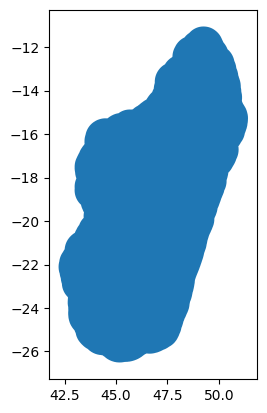

In [3]:
adm = codab.load_codab()
buffer = True
if buffer:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:29702)
    gdf_adm0_buffer = adm.to_crs(epsg=constants.mdg_epsg)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    adm = gdf_adm0_buffer.to_crs(adm.crs)
else:
    adm = adm.copy()
adm.plot()

In [4]:
df = rsmc.load_historical_forecast_distances()

In [5]:
ibtracs_path = rsmc.DATA_DIR / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)

In [6]:
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * 0.88
)
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])

<Axes: >

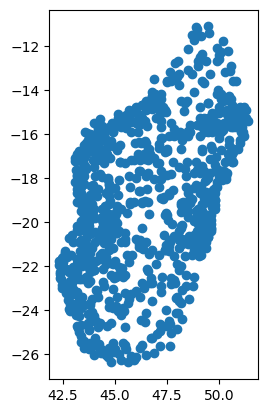

In [7]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel.plot()

In [8]:
df.columns

Index(['valid_time', 'lt_hour', 'latitude', 'longitude', 'max_wind_kt',
       'season', 'name', 'numberseason', 'issue_time', 'MG_distance_km'],
      dtype='object')

In [9]:
df["issue_time"].unique()

<DatetimeArray>
['2010-10-25 12:00:00+00:00', '2010-10-25 18:00:00+00:00',
 '2010-10-26 00:00:00+00:00', '2010-10-26 06:00:00+00:00',
 '2010-10-26 12:00:00+00:00', '2010-10-26 18:00:00+00:00',
 '2010-10-27 00:00:00+00:00', '2010-10-27 06:00:00+00:00',
 '2010-10-27 12:00:00+00:00', '2010-10-27 18:00:00+00:00',
 ...
 '2021-04-22 06:00:00+00:00', '2021-04-22 12:00:00+00:00',
 '2021-04-22 18:00:00+00:00', '2021-04-23 00:00:00+00:00',
 '2021-04-23 06:00:00+00:00', '2021-04-23 12:00:00+00:00',
 '2021-04-23 18:00:00+00:00', '2021-04-24 00:00:00+00:00',
 '2021-04-24 06:00:00+00:00', '2021-04-24 12:00:00+00:00']
Length: 3109, dtype: datetime64[ns, UTC]

In [10]:
df_6hr = df[df["lt_hour"] % 6 == 0]

## Comparing against IBTrACS

In [12]:
gdf_points

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,STORM_SPD,STORM_DR,year,month,day,hour,min,geometry,Date,REU_USA_WIND
0,1848011S09079,1848,1,SI,MM,UNNAMED,1848-01-11 06:00:00+00:00,NR,-9.0,79.0,...,26.0,250.0,1848,1,11,6,0,POINT (79 -9),1848-01-11,NaN
1,1848011S09079,1848,1,SI,MM,UNNAMED,1848-01-11 09:00:00+00:00,NR,-9.4,77.7,...,26.0,250.0,1848,1,11,9,0,POINT (77.7 -9.4),1848-01-11,NaN
2,1848011S09079,1848,1,SI,MM,UNNAMED,1848-01-11 12:00:00+00:00,NR,-9.8,76.5,...,26.0,250.0,1848,1,11,12,0,POINT (76.5 -9.8),1848-01-11,NaN
3,1848011S09079,1848,1,SI,MM,UNNAMED,1848-01-11 15:00:00+00:00,NR,-10.3,75.2,...,26.0,250.0,1848,1,11,15,0,POINT (75.2 -10.3),1848-01-11,NaN
4,1848011S09079,1848,1,SI,MM,UNNAMED,1848-01-11 18:00:00+00:00,NR,-10.8,74.0,...,26.0,245.0,1848,1,11,18,0,POINT (74 -10.8),1848-01-11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166607,2024276S10076,2025,70,SI,MM,ANCHA,2024-10-05 06:00:00+00:00,NR,-16.9,66.6,...,4.0,300.0,2024,10,5,6,0,POINT (66.6 -16.9),2024-10-05,16.72
166608,2024276S10076,2025,70,SI,MM,ANCHA,2024-10-05 09:00:00+00:00,NR,-16.7,66.5,...,4.0,335.0,2024,10,5,9,0,POINT (66.5 -16.7),2024-10-05,16.72
166609,2024276S10076,2025,70,SI,MM,ANCHA,2024-10-05 12:00:00+00:00,NR,-16.5,66.4,...,4.0,325.0,2024,10,5,12,0,POINT (66.4 -16.5),2024-10-05,16.72
166610,2024276S10076,2025,70,SI,MM,ANCHA,2024-10-05 15:00:00+00:00,NR,-16.4,66.3,...,3.0,290.0,2024,10,5,15,0,POINT (66.3 -16.4),2024-10-05,16.72


C:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-mdg-storms\src\datasources\helpers.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["valid_time"] = pd.to_datetime(df["valid_time"], utc=True)


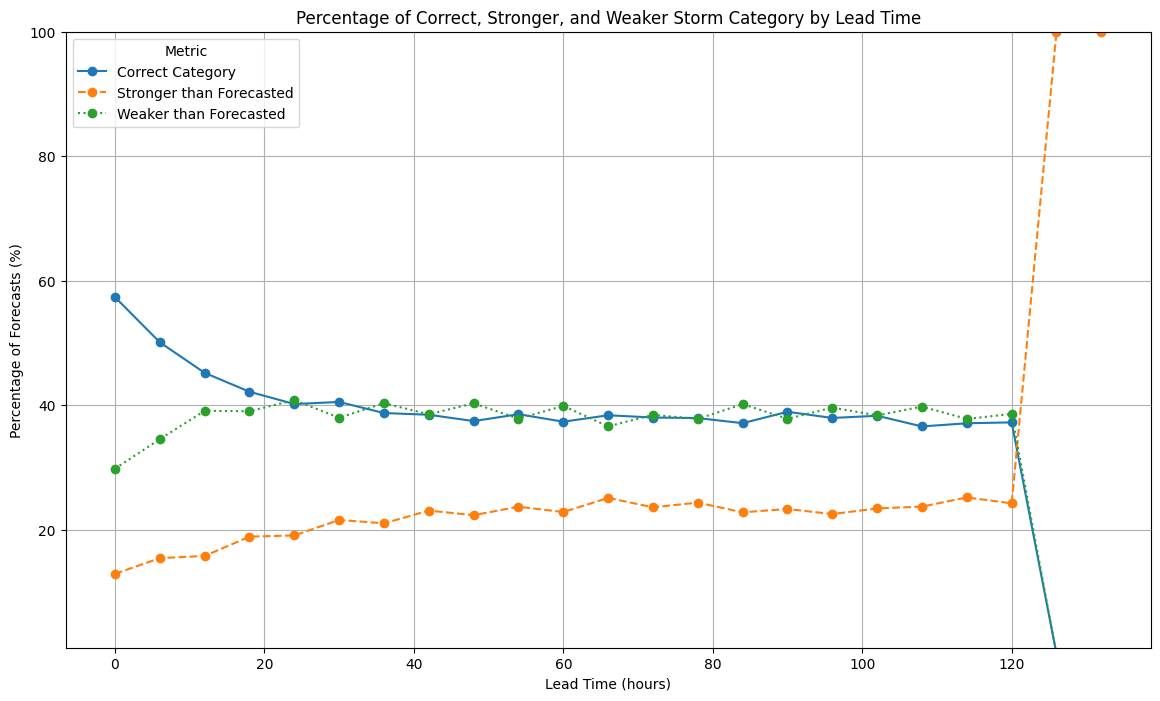

In [11]:
combined_metrics = helpers.calculate_metrics_by_category_mflr_ibtracs(
    gdf_points,
    df_6hr,
    categorize_cyclone,
    category_order,
    longitude_cutoffs=None,
    buffer_kms=None,
    storm_category_filters=None,
)

# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lt_hour").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot stronger than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle="--",
    label="Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lt_hour"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.ylim(1, 100)
plt.grid(True)
plt.show()